# OLG Model Transition Path Analysis
移行過程分析と結果の可視化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from olg_solver import solve_ss, Setting, SteadyStateResult, TransitionSetting
from olg_transition_solver import create_capital_guess, solve_transition_path

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. OLG Model Setup and Transition Calculation
移行過程の設定と計算

In [ ]:
def create_policy_function_boxes(tr_setting, setting):
    """
    移行過程の政策関数とそのインデックスの箱を作成
    - opt_indexes: 政策関数インデックス (NT, NJ, Nl, Na)
    - aprimes: 政策関数実数値 (NT, NJ, Nl, Na)
    """
    shape = (tr_setting.NT, setting.NJ, setting.Nl, setting.Na)
    opt_indexes = np.zeros(shape, dtype=np.int32)
    aprimes = np.zeros(shape, dtype=np.float64)
    return opt_indexes, aprimes

def run_transition_analysis():
    """移行過程分析を実行"""
    print("=== OLG移行過程分析 ===")
    
    # 移行過程の設定を作成
    tr_setting = TransitionSetting(
        NT=100,    # 移行期間
        TT=25,     # 政策変更期間
        psi_ini=0.5,  # 初期所得代替率
        psi_fin=0.25  # 最終所得代替率
    )
    
    tr_setting.print_transition_summary()
    
    # 初期・最終定常状態用のSetting作成
    print("\n=== 定常状態用設定の作成 ===")
    initial_setting, final_setting = tr_setting.create_ss_settings(
        Na=101,        # 資産グリッド数
        Naprime=2001   # 政策関数用資産グリッド数
    )
    
    print(f"初期定常状態設定: ψ = {initial_setting.psi:.3f}")
    print(f"最終定常状態設定: ψ = {final_setting.psi:.3f}")
    
    # 1. 初期・最終定常状態の計算
    print("\n=== 初期定常状態の計算 ===")
    initial_result = solve_ss(initial_setting)
    mu_ini = initial_result.mu_dist_box
    K_ini = initial_result.K
    
    print("\n=== 最終定常状態の計算 ===")
    final_result = solve_ss(final_setting)
    V_fin = final_result.value_fun_box
    K_fin = final_result.K
    
    # 2. 移行過程の初期設定
    print("\n=== 移行過程の初期設定 ===")
    # K_path = create_capital_guess(tr_setting, K_ini, K_fin)
    K_path = np.load('K_path.npy')  # 事前に計算した資本パスを読み込み(サクッと実行用)
    
    # 政策関数とそのインデックスの箱を用意
    opt_indexes, aprimes = create_policy_function_boxes(tr_setting, initial_setting)

    # 移行過程の反復計算（価値関数も取得）
    print("\n=== 移行過程の反復計算 ===")
    converged_K_path, value_functions = solve_transition_path(
        tr_setting, initial_setting, K_path, opt_indexes, aprimes, V_fin, mu_ini
    )
    
    return tr_setting, initial_result, final_result, converged_K_path, opt_indexes, aprimes, value_functions

In [3]:
# 移行過程分析を実行（価値関数も取得）
tr_setting, initial_result, final_result, K_path, opt_indexes, aprimes, value_functions = run_transition_analysis()

=== OLG移行過程分析 ===

=== 移行過程設定サマリー ===
移行期間: 100 期
政策変更収束期間: 25 期
初期所得代替率: 0.500
最終所得代替率: 0.250
移行過程用収束判定閾値: 1.0e-04
移行過程用最大繰り返し回数: 300
移行過程用資本更新調整係数: 0.050

主要期間の所得代替率:
  第1期: ψ = 0.500, τ = 0.178
  第7期: ψ = 0.438, τ = 0.156
  第13期: ψ = 0.375, τ = 0.133
  第25期: ψ = 0.250, τ = 0.089
  第100期: ψ = 0.250, τ = 0.089

=== 定常状態用設定の作成 ===
初期定常状態設定: ψ = 0.500
最終定常状態設定: ψ = 0.250

=== 初期定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 6.803420e-01, errm = 0.000000e+00
Iteration 2: market_diff = 1.284662e-01, errm = 0.000000e+00
Iteration 3: market_diff = 2.420232e-02, errm = 0.000000e+00
Iteration 4: market_diff = 3.463949e-03, errm = 0.000000e+00
Iteration 5: market_diff = 1.147234e-03, errm = 0.000000e+00
\n計算完了! 実行時間: 3.52秒
総イテレーション数: 6
最終市場差: 1.292885e-04
最終人口合計誤差: 0.000000e+00
収束した資本ストック K = 6.1675

=== 最終定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 3.147847e+00, errm = 0.000000e+00
Iteration 2: market_diff = 7.246067e-01, errm = 0.000000e+00
Iteration 3: m

## 2. Capital Path Analysis
資本パスの分析と可視化

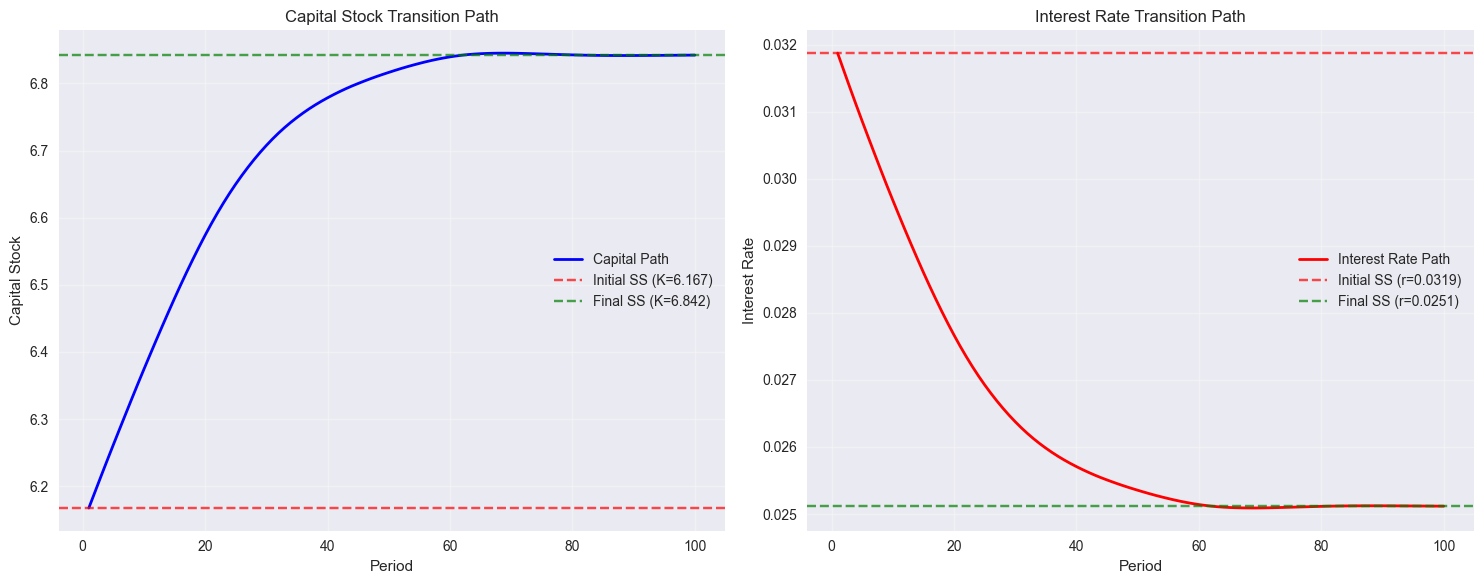

In [4]:
def calculate_factor_prices_path(tr_setting, K_path, initial_setting):
    """移行過程の要素価格を計算"""
    L = initial_setting.Njw / initial_setting.NJ  # 労働供給
    
    r_path = np.zeros(tr_setting.NT)
    w_path = np.zeros(tr_setting.NT)
    
    for t in range(tr_setting.NT):
        K_t = K_path[t]
        r_path[t] = initial_setting.alpha * (K_t / L) ** (initial_setting.alpha - 1) - initial_setting.delta
        w_path[t] = (1 - initial_setting.alpha) * (K_t / L) ** initial_setting.alpha
    
    return r_path, w_path

def plot_capital_path(tr_setting, K_path, initial_result, final_result):
    """資本パスと金利パスをプロット"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 資本パス
    periods = np.arange(1, tr_setting.NT + 1)
    ax1.plot(periods, K_path, 'b-', linewidth=2, label='Capital Path')
    ax1.axhline(y=initial_result.K, color='red', linestyle='--', alpha=0.7, label=f'Initial SS (K={initial_result.K:.3f})')
    ax1.axhline(y=final_result.K, color='green', linestyle='--', alpha=0.7, label=f'Final SS (K={final_result.K:.3f})')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Capital Stock')
    ax1.set_title('Capital Stock Transition Path')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 金利パス
    r_path, _ = calculate_factor_prices_path(tr_setting, K_path, initial_result.hp)
    ax2.plot(periods, r_path, 'r-', linewidth=2, label='Interest Rate Path')
    ax2.axhline(y=initial_result.r, color='red', linestyle='--', alpha=0.7, label=f'Initial SS (r={initial_result.r:.4f})')
    ax2.axhline(y=final_result.r, color='green', linestyle='--', alpha=0.7, label=f'Final SS (r={final_result.r:.4f})')
    ax2.set_xlabel('Period')
    ax2.set_ylabel('Interest Rate')
    ax2.set_title('Interest Rate Transition Path')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_capital_path(tr_setting, K_path, initial_result, final_result)

In [5]:
def calculate_cev_with_value_functions(tr_setting, initial_result, value_functions):
    """
    価値関数を使って消費補償変分（CEV）を計算
    
    初期定常状態をベースライン、第1期を比較対象としたCEVを計算
    横軸：年齢、縦軸：CEV
    
    Parameters
    ----------
    tr_setting : TransitionSetting
        移行過程設定
    initial_result : SteadyStateResult
        初期定常状態の結果
    value_functions : dict
        {'V_init': 改革時点価値関数, 'V_start': 各期出生時価値}
        
    Returns
    -------
    dict
        CEV計算結果
    """
    print("=== 価値関数を使った真のCEV計算 ===")
    print("ベースライン: 初期定常状態")
    print("比較対象: 改革第1期")
    print()
    
    setting = initial_result.hp
    V_baseline = initial_result.value_fun_box  # 初期定常状態の価値関数
    V_transition = value_functions['V_init']   # 改革第1期の価値関数
    
    # 年齢ごとの割引係数: β^0 + β^1 + ... + β^{NJ-j-1}
    beta_j = np.array([
        np.sum([setting.beta**i for i in range(setting.NJ - j)])
        for j in range(setting.NJ)
    ])
    
    # CEV計算: exp((V_transition - V_baseline) / beta_j) - 1
    if setting.gamma == 1.0:
        # log効用の場合
        cev_full = np.exp((V_transition - V_baseline) / beta_j[:, None, None]) - 1
    else:
        # CRRA効用の場合の近似
        cev_full = np.power(
            (1 - setting.gamma) * (V_transition - V_baseline) / beta_j[:, None, None] + 1,
            1 / (1 - setting.gamma)
        ) - 1
    
    # 人口分布で重み付けした年齢×スキル平均CEV
    mu_dist = initial_result.mu_dist_box
    cev_age_skill = (cev_full * mu_dist).sum(axis=2) / (mu_dist.sum(axis=2) + 1e-10)
    
    # 年齢別平均CEV（全スキル・全資産を重み付け平均）
    cev_age_avg = (cev_full * mu_dist).sum(axis=(1, 2)) / (mu_dist.sum(axis=(1, 2)) + 1e-10)
    
    return {
        'cev_full': cev_full,               # (NJ, Nl, Na)
        'cev_age_skill': cev_age_skill,     # (NJ, Nl)  
        'cev_age_avg': cev_age_avg,         # (NJ,)
        'beta_j': beta_j,
        'setting': setting,
        'mu_dist': mu_dist
    }

def plot_cev_by_age(cev_results):
    """
    年齢別CEVをプロット（要望通りの単一グラフ）
    
    Parameters
    ----------
    cev_results : dict
        calculate_cev_with_value_functions()の戻り値
    """
    setting = cev_results['setting']
    cev_age_skill = cev_results['cev_age_skill']
    cev_age_avg = cev_results['cev_age_avg']
    
    # 年齢軸（20歳から開始と仮定）
    ages = np.arange(20, 20 + setting.NJ)
    
    plt.figure(figsize=(12, 8))
    
    # 年齢×スキル別CEV
    plt.plot(ages, cev_age_skill[:, 0], '--k', linewidth=2, label='Low skill', marker='o', markersize=4)
    plt.plot(ages, cev_age_skill[:, 1], '-k', linewidth=2, label='High skill', marker='s', markersize=4)
    
    # 年齢別平均CEV
    plt.plot(ages, cev_age_avg, '-r', linewidth=3, label='Average', alpha=0.8)
    
    # ゼロ線
    plt.axhline(y=0, color='gray', linestyle=':', alpha=0.7)
    
    plt.xlabel('Age')
    plt.ylabel('Consumption Equivalent Variation (CEV)')
    plt.title('CEV by Age: Initial Steady State vs. Transition Period 1')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # パーセンテージ表示用の補助軸
    ax_pct = plt.gca().twinx()
    ax_pct.set_ylabel('CEV (%)')
    ax_pct.set_ylim(np.array(plt.gca().get_ylim()) * 100)
    
    plt.tight_layout()
    plt.show()
    
    # 数値サマリー
    print(f"\\n=== CEV サマリー（初期定常状態 vs 移行第1期） ===")
    print(f"全年齢平均CEV: {cev_age_avg.mean():.4f} ({cev_age_avg.mean()*100:.2f}%)")
    print(f"低スキル平均CEV: {cev_age_skill[:, 0].mean():.4f} ({cev_age_skill[:, 0].mean()*100:.2f}%)")
    print(f"高スキル平均CEV: {cev_age_skill[:, 1].mean():.4f} ({cev_age_skill[:, 1].mean()*100:.2f}%)")
    
    # 年齢グループ別統計
    young_idx = slice(0, 21)   # 20-40歳  
    middle_idx = slice(20, 41) # 40-60歳
    old_idx = slice(40, None)  # 60歳以上
    
    print(f"\\n=== 年齢グループ別CEV ===")
    if len(cev_age_avg[young_idx]) > 0:
        print(f"若年層（20-40歳）: {cev_age_avg[young_idx].mean():.4f} ({cev_age_avg[young_idx].mean()*100:.2f}%)")
    if len(cev_age_avg[middle_idx]) > 0:
        print(f"中年層（40-60歳）: {cev_age_avg[middle_idx].mean():.4f} ({cev_age_avg[middle_idx].mean()*100:.2f}%)")
    if len(cev_age_avg[old_idx]) > 0:
        print(f"高齢層（60歳以上）: {cev_age_avg[old_idx].mean():.4f} ({cev_age_avg[old_idx].mean()*100:.2f}%)")
    
    # 最大・最小CEVの年齢
    max_cev_age = ages[np.argmax(cev_age_avg)]
    min_cev_age = ages[np.argmin(cev_age_avg)]
    print(f"\\n最大CEV: {cev_age_avg.max():.4f} (年齢{max_cev_age})")
    print(f"最小CEV: {cev_age_avg.min():.4f} (年齢{min_cev_age})")
    
    print(f"\\nCEV解釈:")
    print(f"正の値: 移行により厚生改善（消費をその分増やしたのと等価）")
    print(f"負の値: 移行により厚生悪化（消費をその分減らしたのと等価）")

=== 価値関数を使った真のCEV計算 ===
ベースライン: 初期定常状態
比較対象: 改革第1期



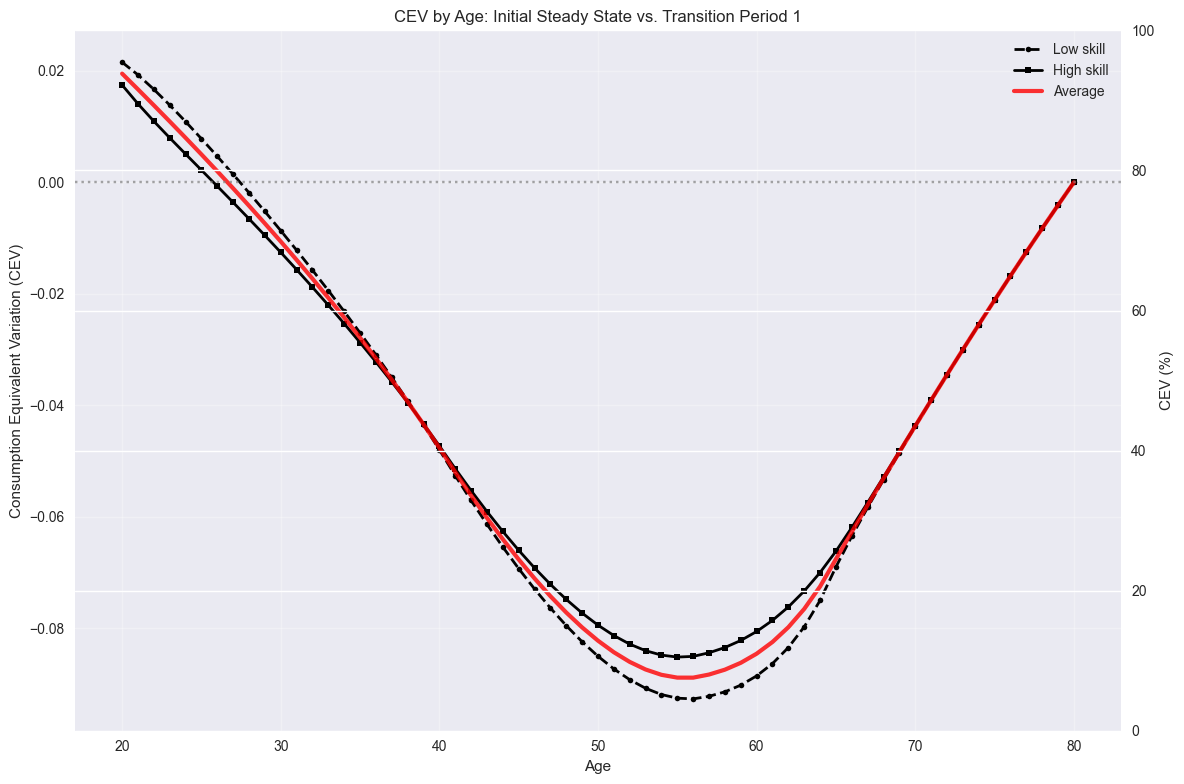

\n=== CEV サマリー（初期定常状態 vs 移行第1期） ===
全年齢平均CEV: -0.0433 (-4.33%)
低スキル平均CEV: -0.0439 (-4.39%)
高スキル平均CEV: -0.0427 (-4.27%)
\n=== 年齢グループ別CEV ===
若年層（20-40歳）: -0.0119 (-1.19%)
中年層（40-60歳）: -0.0763 (-7.63%)
高齢層（60歳以上）: -0.0439 (-4.39%)
\n最大CEV: 0.0195 (年齢20)
最小CEV: -0.0888 (年齢56)
\nCEV解釈:
正の値: 移行により厚生改善（消費をその分増やしたのと等価）
負の値: 移行により厚生悪化（消費をその分減らしたのと等価）


In [6]:
# 価値関数を使った真のCEV計算とプロット
cev_results = calculate_cev_with_value_functions(tr_setting, initial_result, value_functions)
plot_cev_by_age(cev_results)